 # FashionMNIST

 ## Задание 7.2

<img src="https://emiliendupont.github.io/imgs/mnist-chicken/mnist-and-fashion-examples.png">

На практике построим нейронную сеть для классификации картиной. В качестве входных данных используются картинки одежды (в градациях серого, то есть цветовых каналов не 3, а 1). По входной картинке нужно предсказать тип одежды.

In [56]:
# !pip install torchvision

import numpy as np
import matplotlib.pyplot as plt

import torch
import torchvision
import warnings
import torch.nn.functional as F
from torch.autograd import Variable
from tqdm.auto import tqdm
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

# warnings.filterwarnings('ignore')

Скачаем обучающую и контрольную выборки.

In [67]:
transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
                                             torchvision.transforms.Normalize((0.1307,), (0.3081,))])

trainset = torchvision.datasets.FashionMNIST(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.FashionMNIST(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = {0: 'T-shirt/top', \
           1: 'Trouser', \
           2: 'Pullover', \
           3: 'Dress', \
           4: 'Coat', \
           5: 'Sandal', \
           6: 'Shirt', \
           7: 'Sneaker', \
           8: 'Bag', \
           9: 'Ankle boot'}

Каждая картинка имеет класс от 0 до 9, расшифровка меток класса:  

|class_id|class_name|
|----|----|
|0| T-shirt/top|
|1| Trouser|
|2| Pullover|
|3| Dress|
|4| Coat|
|5| Sandal|
|6| Shirt|
|7| Sneaker|
|8| Bag|
|9| Ankle boot|

<h2 style="text-align: center;"><b>Задание</b></h2>

Посмотрите на датасет.
* Сколько картинок в train? В test?
* Равномерно ли распределено количество объектов разных классов в train датасете (это можно понять, поработав с полем `train_data` у переменной `trainset`)? в test?
* Выведите несколько картинок с помощью `pyplot`

Используя материалы семинаров по многослойным  и свёрточным сетям, напишите:
1.  Многослойную нейронную сеть MLP (Multi-Layer Perceptron) классифицирующую этот датасет
2. Свёрточную сеть, классифицирующую этот датасет
3. Сравните их качество (по графикам лосса и по Accuracy Score)

Если качество, которое получается у  нейросети, выше 95%, то Вы решили задачу с точностью, которую можно использовать в жизни.

In [3]:
import pandas as pd
from tqdm import notebook

In [68]:
trainset.data.shape

torch.Size([60000, 28, 28])

In [69]:
testset.data.shape

torch.Size([10000, 28, 28])

In [70]:
pd_trainset = pd.DataFrame(trainset.targets.numpy())

for i in range(10):
  print("class", i, ":", (pd_trainset == i).sum())

class 0 : 0    6000
dtype: int64
class 1 : 0    6000
dtype: int64
class 2 : 0    6000
dtype: int64
class 3 : 0    6000
dtype: int64
class 4 : 0    6000
dtype: int64
class 5 : 0    6000
dtype: int64
class 6 : 0    6000
dtype: int64
class 7 : 0    6000
dtype: int64
class 8 : 0    6000
dtype: int64
class 9 : 0    6000
dtype: int64


In [71]:
pd_testset = pd.DataFrame(testset.targets.numpy())

for i in range(10):
  print("class", i, ":", (pd_testset == i).sum())

class 0 : 0    1000
dtype: int64
class 1 : 0    1000
dtype: int64
class 2 : 0    1000
dtype: int64
class 3 : 0    1000
dtype: int64
class 4 : 0    1000
dtype: int64
class 5 : 0    1000
dtype: int64
class 6 : 0    1000
dtype: int64
class 7 : 0    1000
dtype: int64
class 8 : 0    1000
dtype: int64
class 9 : 0    1000
dtype: int64


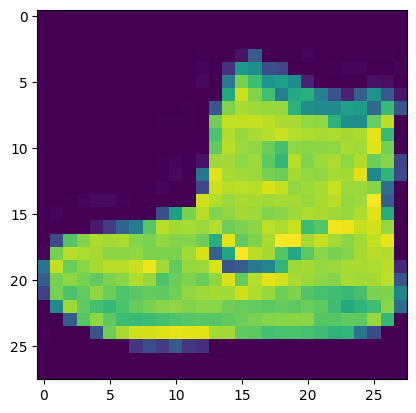

In [72]:
plt.imshow(trainset.data[0])

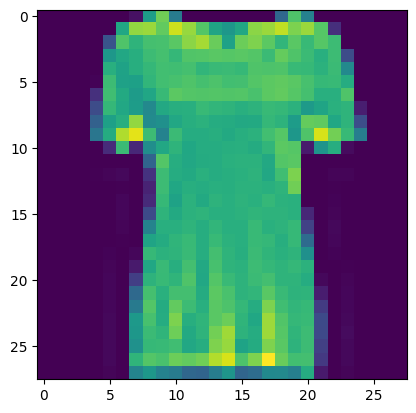

In [73]:
plt.imshow(trainset.data[10])

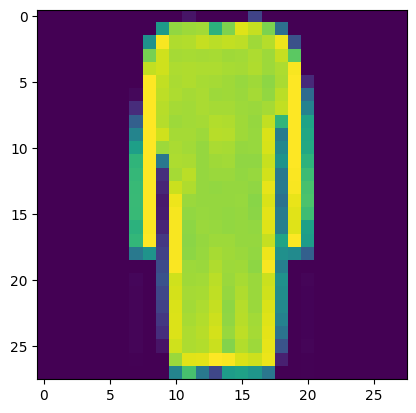

In [74]:
plt.imshow(trainset.data[25])

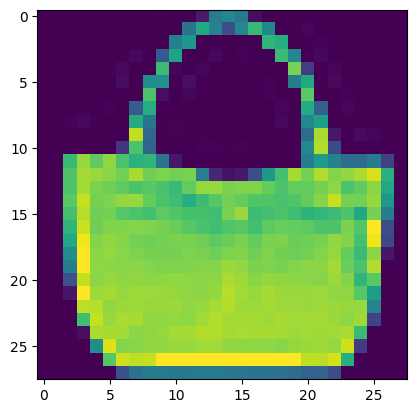

In [75]:
plt.imshow(trainset.data[100])

In [88]:
def fit(model, trainloader, optimizer, loss_function, num_epochs = 10):
  loss_values = []

  for epoch in tqdm(range(num_epochs)):
    for i, (images, labels) in enumerate(trainloader):
      images = Variable(images.cuda())
      labels = Variable(labels.cuda())
      optimizer.zero_grad()
      loss = loss_function(model(images), labels)
      loss.backward()
      optimizer.step()

      if(i == 1000):
        loss_values.append(loss.detach().cpu().item())

  plt.plot(loss_values)
  plt.show()

def predict(model, testloader):
  model.eval()
  y_trues = list()
  y_predicted = list()

  with torch.no_grad():
    for batch in testloader:
      y_pred = model(batch[0].cuda())
      y_hat = torch.argmax(y_pred, dim=1).detach().cpu()
      y_trues.extend(batch[1])
      y_predicted.extend(y_hat)

  print(classification_report(y_predicted, y_trues))

In [77]:
class MLP(torch.nn.Module):
  def __init__(self, D_in, H, D_out):
    super(MLP, self).__init__()

    self.first_layer = torch.nn.Linear(D_in, H[0])
    self.first_ReLu = torch.nn.ReLU()
    self.second_layer = torch.nn.Linear(H[0], H[1])
    self.second_ReLu = torch.nn.ReLU()
    self.third_layer = torch.nn.Linear(H[1], D_out)

  def forward(self, x):
    x = x.view(-1, 784)
    x = self.first_layer(x)
    x = self.first_ReLu(x)
    x = self.second_layer(x)
    x = self.second_ReLu(x)
    x = self.third_layer(x)

    return x

In [81]:
model = MLP(784, [256, 128], 10)
model.cuda()
model.train()

for parameter in model.parameters():
  parameter.requires_grad = True

learning_rate = 0.0001
loss_function = torch.nn.CrossEntropyLoss(reduction="sum")
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

  0%|          | 0/10 [00:00<?, ?it/s]

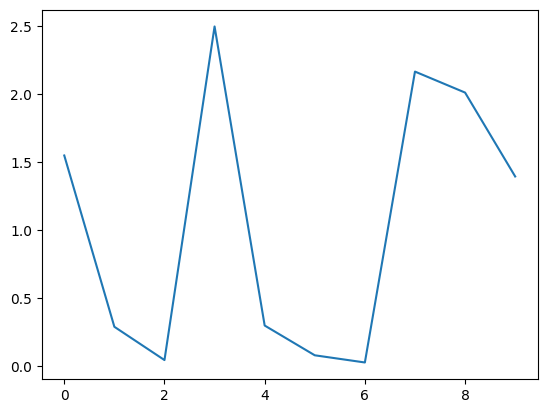

              precision    recall  f1-score   support

           0       0.84      0.85      0.85       996
           1       0.98      0.98      0.98      1007
           2       0.83      0.80      0.81      1046
           3       0.87      0.91      0.89       962
           4       0.79      0.82      0.80       963
           5       0.97      0.97      0.97       994
           6       0.73      0.70      0.72      1038
           7       0.96      0.95      0.96      1014
           8       0.96      0.99      0.98       977
           9       0.96      0.96      0.96      1003

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000



In [82]:
fit(model, trainloader, optimizer, loss_function)
predict(model, testloader)

In [83]:
class CNN(torch.nn.Module):
  def __init__(self, D_in, H, D_out):
    super(CNN, self).__init__()

    self.first_conv = torch.nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5)
    self.pool = torch.nn.MaxPool2d(kernel_size=2, stride=2)
    self.second_conv = torch.nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5)
    self.first_layer = torch.nn.Linear(D_in, H[0])
    self.second_layer = torch.nn.Linear(H[0], H[1])
    self.third_layer = torch.nn.Linear(H[1], D_out)

  def forward(self, x):
    x = self.pool(F.relu(self.first_conv(x)))
    x = self.pool(F.relu(self.second_conv(x)))
    x = x.view(-1, 4 * 4 * 16)
    x = F.relu(self.first_layer(x))
    x = F.relu(self.second_layer(x))
    x = self.third_layer(x)

    return x

In [85]:
model = CNN(256, [256, 128], 10)
model.cuda()
model.train()

for parameter in model.parameters():
  parameter.requires_grad = True

learning_rate = 0.0001
loss_function = torch.nn.CrossEntropyLoss(reduction="sum")
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

  0%|          | 0/10 [00:00<?, ?it/s]

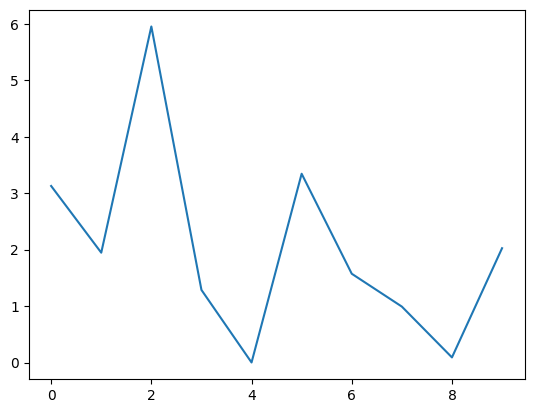

              precision    recall  f1-score   support

           0       0.81      0.86      0.84       951
           1       0.98      0.99      0.99       985
           2       0.79      0.88      0.83       899
           3       0.90      0.89      0.90      1009
           4       0.87      0.77      0.82      1130
           5       0.98      0.97      0.97      1010
           6       0.71      0.69      0.70      1025
           7       0.98      0.92      0.95      1063
           8       0.97      0.98      0.97       994
           9       0.92      0.99      0.95       934

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000



In [86]:
fit(model, trainloader, optimizer, loss_function)
predict(model, testloader)